<a href="https://colab.research.google.com/github/MLFlexer/nlp-course/blob/Emma/bert_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install bpemb
!pip install gensim
!pip install datasets
!pip install transformers
!python -m spacy download en_core_web_sm

2023-10-21 13:54:03.677187: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-10-21 13:54:04.708384: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
2023-10-21 13:54:06.082558: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-10-21 13:54:06.083050: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA n

In [2]:
# add-in as occasionally receive an error which requires this to be added
# uncomment if the issue arises
!pip install transformer[torch]

ERROR: Could not find a version that satisfies the requirement transformer[torch] (from versions: none)
ERROR: No matching distribution found for transformer[torch]


In [3]:
import os
import numpy as np
from collections import Counter
import torch
import datasets
datasets.logging.set_verbosity_error()
from datasets import load_metric
from google.colab import drive
from transformers import Trainer, TrainingArguments, AutoTokenizer, AutoModelForSequenceClassification
from sklearn.metrics import cohen_kappa_score
from sklearn.metrics import f1_score
import pandas as pd

from sklearn.model_selection import train_test_split
from transformers import BertTokenizer, BertForSequenceClassification, AdamW, get_linear_schedule_with_warmup
import torch
from torch.utils.data import DataLoader, TensorDataset, RandomSampler, SequentialSampler
from tqdm import tqdm
from sklearn.metrics import classification_report, accuracy_score

# # uncomment if CAN'T CONNECT TO GPU (it happens...)
# import psutil
# import platform

In [4]:
# to save output of models so they can be reloaded

from google.colab import drive
drive.mount('/content/drive')
output_dir = '/content/drive/My Drive/Colab Notebooks/NLP/'


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [5]:
# GPU housekeeping code: you do not need to modify anything, simply
# read through it to understand what is going on, and run as is

device = "cuda:0" if torch.cuda.is_available() else "cpu"

# a helper function to format byte counts into KB, MB and so on
def bytes_format(b):
    if b < 1000:
              return f'{b} B'
    elif b < 1000000:
        return f'{round(float(b/1000),2)} KB'
    elif b < 1000000000:
        return f'{round(float(b/1000000),2)} MB'
    else:
        return f'{round(float(b/1000000000),2)} GB'

# a helper function to check the amount of available memory
def memory_report():
  if device!='cpu':
    print(f"GPU available: {torch.cuda.get_device_name()}")
    #print(torch.cuda.memory_summary())
    total = torch.cuda.get_device_properties(0).total_memory
    reserved = torch.cuda.memory_reserved(0)
    allocated = torch.cuda.memory_allocated(0)
  #  free = reserved-allocated  # free inside memory_reserved
    print(f"Total cuda memory: {bytes_format(total)}, reserved: {bytes_format(reserved)}, allocated: {bytes_format(allocated)}")
  else:
    # Print total memory available on CPU
    print(f'Device is CPU {platform.processor()}. GPU is not available rn')
    total_memory = psutil.virtual_memory().total
    print(f"Total CPU memory: {bytes_format(total_memory)}")

memory_report()

GPU available: Tesla T4
Total cuda memory: 15.84 GB, reserved: 0 B, allocated: 0 B


In [6]:
# Preamble
import sys

sys.path.append('..')

In [7]:
from datasets import load_dataset
import pandas as pd

dataset = load_dataset("copenlu/answerable_tydiqa")

train_set = dataset["train"]
validation_set = dataset["validation"]

df_train = train_set.to_pandas()
df_val = validation_set.to_pandas()

print(len(df_train))
print(len(df_val))

df_train.head()


116067
13325


,question_text,document_title,language,annotations,document_plaintext,document_url
0,Milloin Charles Fort syntyi?,Charles Fort,finnish,"{'answer_start': [18], 'answer_text': ['6. elo...",Charles Hoy Fort (6. elokuuta (joidenkin lähte...,https://fi.wikipedia.org/wiki/Charles%20Fort
1,“ダン” ダニエル・ジャドソン・キャラハンの出身はどこ,ダニエル・J・キャラハン,japanese,"{'answer_start': [35], 'answer_text': ['カリフォルニ...",“ダン”こと、ダニエル・ジャドソン・キャラハンは1890年7月26日、カリフォルニア州サンフ...,https://ja.wikipedia.org/wiki/%E3%83%80%E3%83%...
2,వేప చెట్టు యొక్క శాస్త్రీయ నామం ఏమిటి?,వేప,telugu,"{'answer_start': [12], 'answer_text': ['Azadir...","వేప (లాటిన్ Azadirachta indica, syn. Melia aza...",https://te.wikipedia.org/wiki/%E0%B0%B5%E0%B1%...
3,চেঙ্গিস খান কোন বংশের রাজা ছিলেন ?,চেঙ্গিজ খান,bengali,"{'answer_start': [414], 'answer_text': ['বোরজি...",চেঙ্গিজ খান (মঙ্গোলীয়: Чингис Хаан আ-ধ্ব-ব: ...,https://bn.wikipedia.org/wiki/%E0%A6%9A%E0%A7%...
4,రెయ్యలగడ్ద గ్రామ విస్తీర్ణత ఎంత?,రెయ్యలగడ్ద,telugu,"{'answer_start': [259], 'answer_text': ['27 హె...","రెయ్యలగడ్ద, విశాఖపట్నం జిల్లా, గంగరాజు మాడుగుల...",https://te.wikipedia.org/wiki/%E0%B0%B0%E0%B1%...


In [8]:
# Get train and validation data for each language
df_train_bengali = df_train[df_train['language'] == 'bengali']
df_train_arabic = df_train[df_train['language'] == 'arabic']
df_train_indonesian = df_train[df_train['language'] == 'indonesian']

df_val_bengali = df_val[df_val['language'] == 'bengali']
df_val_arabic = df_val[df_val['language'] == 'arabic']
df_val_indonesian = df_val[df_val['language'] == 'indonesian']


# For testing
df_val_english = df_val[df_val['language'] == 'english']
df_train_english = df_train[df_train['language'] == 'english']


In [9]:
# Create a new dataframe with the combined documents and questions and add if they are answerable
df_train_bengali_merged = pd.DataFrame({
    'text':(df_train_bengali["document_plaintext"] + df_train_bengali["question_text"]),
    'answerable':(df_train_bengali["annotations"].apply(lambda x: 0 if x['answer_start'] == [-1] else 1))
    })
df_train_arabic_merged = pd.DataFrame({
    'text': (df_train_arabic["document_plaintext"] + df_train_arabic["question_text"]),
    'answerable': (df_train_arabic["annotations"].apply(lambda x: 0 if x['answer_start'] == [-1] else 1))
                                    })
df_train_indonesian_merged = pd.DataFrame({
    'text':(df_train_indonesian["document_plaintext"] + df_train_indonesian["question_text"]),
    'answerable':(df_train_indonesian["annotations"].apply(lambda x: 0 if x['answer_start'] == [-1] else 1))
    })
df_train_english_merged = pd.DataFrame({
    'text':(df_train_english["document_plaintext"] + df_train_english["question_text"]),
    'answerable':(df_train_english["annotations"].apply(lambda x: 0 if x['answer_start'] == [-1] else 1))
    })


## Same for validation data
df_val_bengali_merged = pd.DataFrame({
    'text':(df_val_bengali["document_plaintext"] + df_val_bengali["question_text"]),
    'answerable':(df_val_bengali["annotations"].apply(lambda x: 0 if x['answer_start'] == [-1] else 1))
    })
df_val_arabic_merged = pd.DataFrame({
    'text': (df_val_arabic["document_plaintext"] + df_val_arabic["question_text"]),
    'answerable': (df_val_arabic["annotations"].apply(lambda x: 0 if x['answer_start'] == [-1] else 1))
                                    })
df_val_indonesian_merged = pd.DataFrame({
    'text':(df_val_indonesian["document_plaintext"] + df_val_indonesian["question_text"]),
    'answerable':(df_val_indonesian["annotations"].apply(lambda x: 0 if x['answer_start'] == [-1] else 1))
    })
df_val_english_merged = pd.DataFrame({
    'text':(df_val_english["document_plaintext"] + df_val_english["question_text"]),
    'answerable':(df_val_english["annotations"].apply(lambda x: 0 if x['answer_start'] == [-1] else 1))
    })

df_val_english_merged.head()

,text,answerable
30,Wound care encourages and speeds wound healing...,1
47,Brothers Amos and Wilfrid Ayre founded Burntis...,1
59,"For species of mammals, larger brains (in abso...",1
77,"As from 31 March 1989, fishing vessel registra...",1
106,"When Quezon City was created in 1939, the foll...",1


In [10]:
tokenizer = BertTokenizer.from_pretrained("bert-base-multilingual-cased")

# Tokenize and encode the text data
def tokenize_text(texts, max_length=128):
    input_ids = []
    attention_masks = []

    for text in texts:
        encoded_text = tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            max_length=max_length,
            padding="max_length",
            truncation=True,
            return_attention_mask=True,
            return_tensors="pt"
        )
        input_ids.append(encoded_text["input_ids"])
        attention_masks.append(encoded_text["attention_mask"])

    input_ids = torch.cat(input_ids, dim=0)
    attention_masks = torch.cat(attention_masks, dim=0)

    return input_ids, attention_masks

train_input_ids, train_attention_masks = tokenize_text(df_train_english_merged["text"].tolist())
val_input_ids, val_attention_masks = tokenize_text(df_val_english_merged["text"].tolist())
train_labels = torch.tensor(df_train_english_merged["answerable"].tolist())
val_labels = torch.tensor(df_val_english_merged["answerable"].tolist())


In [11]:
batch_size = 32

train_data = TensorDataset(train_input_ids.to('cuda'), train_attention_masks.to('cuda'), train_labels.to('cuda'))
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

val_data = TensorDataset(val_input_ids.to('cuda'), val_attention_masks.to('cuda'), val_labels.to('cuda'))
val_sampler = SequentialSampler(val_data)
val_dataloader = DataLoader(val_data, sampler=val_sampler, batch_size=batch_size)



In [12]:
# checking if cuda is available
print(torch.cuda.is_available())


True


In [13]:
model = BertForSequenceClassification.from_pretrained("bert-base-multilingual-cased", num_labels=2, output_attentions=True)
model.cuda()  # Use GPU for training if available


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-multilingual-cased and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(119547, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12

In [14]:
# the below is taken from the ASDS exam - check whether this is the way to do it or combine with the rest
# first check for english version and then adapt for other languages
!pip install transformers[torch] accelerate



In [15]:
#define parameters for the model
training_args = TrainingArguments(output_dir="my_trainer",
                                  evaluation_strategy="steps",
                                  num_train_epochs=3.0,
                                  per_device_train_batch_size=16,
                                  eval_steps=500
                                  )

In [16]:
# define the compute_metrics function for the trainer
metric_f1 = load_metric('f1')
metric_ac = load_metric('accuracy')

def compute_metrics(eval_pred):
    outputs, labels = eval_pred
    predictions = np.argmax(outputs, axis=-1)
    f1 = metric_f1.compute(predictions=predictions, references=labels)
    ac = metric_ac.compute(predictions=predictions, references=labels)
    return f1 | ac

<ipython-input-16-44264bb71349>:2: FutureWarning: load_metric is deprecated and will be removed in the next major version of datasets. Use 'evaluate.load' instead, from the new library 🤗 Evaluate: https://huggingface.co/docs/evaluate
  metric_f1 = load_metric('f1')


In [17]:
# define the trainer object
trainer_eng = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_input_ids,
    eval_dataset=val_input_ids,
    compute_metrics=compute_metrics,
    tokenizer=tokenizer
)

In [18]:
# print(f'Training loss:\n {trainer.state.log_history[0]["loss"]}\n {trainer.state.log_history[2]["loss"]}\n {trainer.state.log_history[4]["loss"]}\n')
# print(f'Validation loss:\n {trainer.state.log_history[1]["eval_loss"]}\n {trainer.state.log_history[3]["eval_loss"]}\n {trainer.state.log_history[5]["eval_loss"]}')

In [19]:
optimizer = AdamW(model.parameters(), lr=2e-5, eps=1e-8)
epochs = 4
total_steps = len(train_dataloader) * epochs
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=0, num_training_steps=total_steps)


/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [20]:
print(model.device)
print(train_input_ids[0].device)
# print(attention_masks[0].device)
print(train_labels.device)


cuda:0
cpu
cpu


In [21]:
train_input_ids.cuda()

tensor([[   101,  56984,  13939,  ...,      0,      0,      0],
        [   101,  10117,  16280,  ...,  10454, 106482,    102],
        [   101,  18552,  42507,  ...,  10684,    119,    102],
        ...,
        [   101,  72447,  10133,  ...,      0,      0,      0],
        [   101,  10167,  10105,  ...,  41654,    117,    102],
        [   101,  10117,  16741,  ...,      0,      0,      0]],
       device='cuda:0')

In [ ]:
# Move input data to the GPU
# inputs = [item.to("cuda") for item in inputs]
# attention_masks = [item.to("cuda") for item in attention_masks]



# Training loop
for epoch in range(epochs):
    model.train()
    for batch in tqdm(train_dataloader, desc=f"Epoch {epoch + 1}"):


        inputs = batch[:2]
        labels = batch[2]

        model.zero_grad()
        outputs = model(*inputs, labels=labels)
        loss = outputs.loss
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()
        scheduler.step()

    model.eval()
    predictions = []
    true_labels = []
    for batch in tqdm(val_dataloader, desc=f"Evaluating Epoch {epoch + 1}"):
        inputs = batch[:2]
        labels = batch[2]
        with torch.no_grad():
            outputs = model(*inputs)
        logits = outputs.logits
        predictions.extend(logits.argmax(dim=1).tolist())
        true_labels.extend(labels.tolist())

    accuracy = accuracy_score(true_labels, predictions)
    report = classification_report(true_labels, predictions, target_names=["Not Answerable", "Answerable"])
    print(f"Epoch {epoch + 1} - Accuracy: {accuracy:.4f}")
    print(report)

# Saving to Google Drive
    save_path = "/content/drive/My Drive/Colab Notebooks/NLP/"
    with open(save_path + f"results_epoch_{epoch}.txt", 'w') as f:
        f.write(f"Epoch {epoch + 1} - Accuracy: {accuracy:.4f}\n")
        f.write(report)



Evaluating Epoch 1: 100%|██████████| 31/31 [00:07<00:00,  4.38it/s]


Epoch 1 - Accuracy: 0.8051
                precision    recall  f1-score   support

Not Answerable       0.90      0.69      0.78       495
    Answerable       0.75      0.92      0.83       495

      accuracy                           0.81       990
     macro avg       0.82      0.81      0.80       990
  weighted avg       0.82      0.81      0.80       990



Evaluating Epoch 2: 100%|██████████| 31/31 [00:07<00:00,  4.42it/s]


Epoch 2 - Accuracy: 0.8323
                precision    recall  f1-score   support

Not Answerable       0.87      0.78      0.82       495
    Answerable       0.80      0.88      0.84       495

      accuracy                           0.83       990
     macro avg       0.84      0.83      0.83       990
  weighted avg       0.84      0.83      0.83       990



Evaluating Epoch 3: 100%|██████████| 31/31 [00:07<00:00,  4.42it/s]


Epoch 3 - Accuracy: 0.8293
                precision    recall  f1-score   support

Not Answerable       0.88      0.76      0.82       495
    Answerable       0.79      0.90      0.84       495

      accuracy                           0.83       990
     macro avg       0.84      0.83      0.83       990
  weighted avg       0.84      0.83      0.83       990



Evaluating Epoch 4: 100%|██████████| 31/31 [00:07<00:00,  4.39it/s]


Epoch 4 - Accuracy: 0.8313
                precision    recall  f1-score   support

Not Answerable       0.87      0.78      0.82       495
    Answerable       0.80      0.88      0.84       495

      accuracy                           0.83       990
     macro avg       0.83      0.83      0.83       990
  weighted avg       0.83      0.83      0.83       990



In [ ]:
import torch
from sklearn.metrics import accuracy_score, classification_report
from tqdm import tqdm

# ...

# Training loop
for epoch in range(epochs):
    model.train()
    total_loss = 0  # Initialize the total loss for the epoch

    for batch in tqdm(train_dataloader, desc=f"Epoch {epoch + 1}"):
        inputs = batch[:2]
        labels = batch[2]

        model.zero_grad()
        outputs = model(*inputs, labels=labels)
        loss = outputs.loss
        total_loss += loss.item()  # Accumulate the loss
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()
        scheduler.step()

    average_loss = total_loss / len(train_dataloader)  # Compute the average loss for the epoch

    model.eval()
    predictions = []
    true_labels = []
    for batch in tqdm(val_dataloader, desc=f"Evaluating Epoch {epoch + 1}"):
        inputs = batch[:2]
        labels = batch[2]
        with torch.no_grad():
            outputs = model(*inputs)
        logits = outputs.logits
        predictions.extend(logits.argmax(dim=1).tolist())
        true_labels.extend(labels.tolist())

    accuracy = accuracy_score(true_labels, predictions)
    report = classification_report(true_labels, predictions, target_names=["Not Answerable", "Answerable"])
    print(f"Epoch {epoch + 1} - Accuracy: {accuracy:.4f} - Average Loss: {average_loss:.4f}")
    print(report)

    # Saving to Google Drive
    save_path = "/content/drive/My Drive/Colab Notebooks/NLP/"
    with open(save_path + f"results_epoch_{epoch}.txt", 'w') as f:
        f.write(f"Epoch {epoch + 1} - Accuracy: {accuracy:.4f} - Average Loss: {average_loss:.4f}\n")
        f.write(report)


Evaluating Epoch 1: 100%|██████████| 31/31 [00:07<00:00,  4.41it/s]


Epoch 1 - Accuracy: 0.8313 - Average Loss: 0.1060
                precision    recall  f1-score   support

Not Answerable       0.87      0.78      0.82       495
    Answerable       0.80      0.88      0.84       495

      accuracy                           0.83       990
     macro avg       0.83      0.83      0.83       990
  weighted avg       0.83      0.83      0.83       990



Evaluating Epoch 2: 100%|██████████| 31/31 [00:07<00:00,  4.39it/s]


Epoch 2 - Accuracy: 0.8313 - Average Loss: 0.1093
                precision    recall  f1-score   support

Not Answerable       0.87      0.78      0.82       495
    Answerable       0.80      0.88      0.84       495

      accuracy                           0.83       990
     macro avg       0.83      0.83      0.83       990
  weighted avg       0.83      0.83      0.83       990



Evaluating Epoch 3: 100%|██████████| 31/31 [00:07<00:00,  4.40it/s]


Epoch 3 - Accuracy: 0.8313 - Average Loss: 0.1079
                precision    recall  f1-score   support

Not Answerable       0.87      0.78      0.82       495
    Answerable       0.80      0.88      0.84       495

      accuracy                           0.83       990
     macro avg       0.83      0.83      0.83       990
  weighted avg       0.83      0.83      0.83       990



Evaluating Epoch 4: 100%|██████████| 31/31 [00:07<00:00,  4.41it/s]

Epoch 4 - Accuracy: 0.8313 - Average Loss: 0.1065
                precision    recall  f1-score   support

Not Answerable       0.87      0.78      0.82       495
    Answerable       0.80      0.88      0.84       495

      accuracy                           0.83       990
     macro avg       0.83      0.83      0.83       990
  weighted avg       0.83      0.83      0.83       990



In [ ]:
# testing the above model

# Load the pre-trained BERT model and tokenizer

# Sample input text for testing
input_text = "Sample input text for testing the BERT model."

# Tokenize the input text
inputs = tokenizer(input_text, return_tensors="pt", padding=True, truncation=True)

# Run inference
with torch.no_grad():
    outputs = model(**inputs)

# Interpret the outputs
predicted_class = torch.argmax(outputs.logits).item()
predicted_probabilities = torch.softmax(outputs.logits, dim=1).tolist()[0]

print(f"Predicted Class: {predicted_class}")
print(f"Predicted Probabilities: {predicted_probabilities}")

RuntimeError: ignored

In [ ]:
# create a function for the training loop

In [ ]:
# For Indonesian

train_input_ids_indonesian, train_attention_masks_indonesian = tokenize_text(df_train_indonesian_merged["text"].tolist())
val_input_ids_indonesian, val_attention_masks_indonesian = tokenize_text(df_val_indonesian_merged["text"].tolist())
train_labels_indonesian = torch.tensor(df_train_indonesian_merged["answerable"].tolist())
val_labels_indonesian = torch.tensor(df_val_indonesian_merged["answerable"].tolist())

batch_size = 32

train_data_indonesian = TensorDataset(train_input_ids_indonesian.to('cuda'), train_attention_masks_indonesian.to('cuda'), train_labels_indonesian.to('cuda'))
train_sampler_indonesian = RandomSampler(train_data_indonesian)
train_dataloader_indonesian = DataLoader(train_data_indonesian, sampler=train_sampler_indonesian, batch_size=batch_size)

val_data_indonesian = TensorDataset(val_input_ids_indonesian.to('cuda'), val_attention_masks_indonesian.to('cuda'), val_labels_indonesian.to('cuda'))
val_sampler_indonesian = SequentialSampler(val_data_indonesian)
val_dataloader_indonesian = DataLoader(val_data_indonesian, sampler=val_sampler_indonesian, batch_size=batch_size)



In [ ]:
# define the trainer object
trainer_indonesian = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_input_ids_indonesian,
    eval_dataset=val_input_ids_indonesian,
    compute_metrics=compute_metrics,
    tokenizer=tokenizer
)

In [ ]:
optimizer = AdamW(model.parameters(), lr=2e-5, eps=1e-8)
epochs = 4
total_steps = len(train_dataloader_indonesian) * epochs
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=0, num_training_steps=total_steps)


/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [ ]:
model = model.to("cuda")


# Training loop
for epoch in range(epochs):
    model.train()
    total_loss = 0  # Initialize the total loss for the epoch

    for batch in tqdm(train_dataloader_indonesian, desc=f"Epoch {epoch + 1}"):
        inputs = batch[:2]
        labels = batch[2]

        model.zero_grad()
        outputs = model(*inputs, labels=labels)
        loss = outputs.loss
        total_loss += loss.item()  # Accumulate the loss
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()
        scheduler.step()

    average_loss = total_loss / len(train_dataloader_indonesian)  # Compute the average loss for the epoch

    model.eval()
    predictions = []
    true_labels = []
    for batch in tqdm(val_dataloader_indonesian, desc=f"Evaluating Epoch {epoch + 1}"):
        inputs = batch[:2]
        labels = batch[2]
        with torch.no_grad():
            outputs = model(*inputs)
        logits = outputs.logits
        predictions.extend(logits.argmax(dim=1).tolist())
        true_labels.extend(labels.tolist())

    accuracy = accuracy_score(true_labels, predictions)
    report = classification_report(true_labels, predictions, target_names=["Not Answerable", "Answerable"])
    print(f"Epoch {epoch + 1} - Accuracy: {accuracy:.4f} - Average Loss: {average_loss:.4f}")
    print(report)

    # Saving to Google Drive
    save_path = "/content/drive/My Drive/Colab Notebooks/NLP/"
    with open(save_path + f"indonesian_results_epoch_{epoch}.txt", 'w') as f:
        f.write(f"Epoch {epoch + 1} - Accuracy: {accuracy:.4f}\n")
        f.write(report)

Evaluating Epoch 1: 100%|██████████| 38/38 [00:08<00:00,  4.48it/s]


Epoch 1 - Accuracy: 0.8279 - Average Loss: 0.3813
                precision    recall  f1-score   support

Not Answerable       0.90      0.74      0.81       594
    Answerable       0.78      0.92      0.84       597

      accuracy                           0.83      1191
     macro avg       0.84      0.83      0.83      1191
  weighted avg       0.84      0.83      0.83      1191



Evaluating Epoch 2: 100%|██████████| 38/38 [00:08<00:00,  4.52it/s]


Epoch 2 - Accuracy: 0.8657 - Average Loss: 0.2745
                precision    recall  f1-score   support

Not Answerable       0.86      0.87      0.87       594
    Answerable       0.87      0.86      0.87       597

      accuracy                           0.87      1191
     macro avg       0.87      0.87      0.87      1191
  weighted avg       0.87      0.87      0.87      1191



Evaluating Epoch 3: 100%|██████████| 38/38 [00:08<00:00,  4.48it/s]


Epoch 3 - Accuracy: 0.8665 - Average Loss: 0.1866
                precision    recall  f1-score   support

Not Answerable       0.86      0.87      0.87       594
    Answerable       0.87      0.86      0.87       597

      accuracy                           0.87      1191
     macro avg       0.87      0.87      0.87      1191
  weighted avg       0.87      0.87      0.87      1191



Evaluating Epoch 4: 100%|██████████| 38/38 [00:08<00:00,  4.51it/s]


Epoch 4 - Accuracy: 0.8623 - Average Loss: 0.1254
                precision    recall  f1-score   support

Not Answerable       0.87      0.85      0.86       594
    Answerable       0.86      0.87      0.86       597

      accuracy                           0.86      1191
     macro avg       0.86      0.86      0.86      1191
  weighted avg       0.86      0.86      0.86      1191



In [ ]:
# For Bengali

train_input_ids_bengali, train_attention_masks_bengali = tokenize_text(df_train_bengali_merged["text"].tolist())
val_input_ids_bengali, val_attention_masks_bengali = tokenize_text(df_val_bengali_merged["text"].tolist())
train_labels_bengali = torch.tensor(df_train_bengali_merged["answerable"].tolist())
val_labels_bengali = torch.tensor(df_val_bengali_merged["answerable"].tolist())

batch_size = 32

train_data_bengali = TensorDataset(train_input_ids_bengali.to('cuda'), train_attention_masks_bengali.to('cuda'), train_labels_bengali.to('cuda'))
train_sampler_bengali = RandomSampler(train_data_bengali)
train_dataloader_bengali = DataLoader(train_data_bengali, sampler=train_sampler_bengali, batch_size=batch_size)

val_data_bengali = TensorDataset(val_input_ids_bengali.to('cuda'), val_attention_masks_bengali.to('cuda'), val_labels_bengali.to('cuda'))
val_sampler_bengali = SequentialSampler(val_data_bengali)
val_dataloader_bengali = DataLoader(val_data_bengali, sampler=val_sampler_bengali, batch_size=batch_size)


In [ ]:
# define the trainer object
trainer_bengali = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_input_ids_bengali,
    eval_dataset=val_input_ids_bengali,
    compute_metrics=compute_metrics,
    tokenizer=tokenizer
)

In [ ]:
optimizer = AdamW(model.parameters(), lr=2e-5, eps=1e-8)
epochs = 4
total_steps = len(train_dataloader_bengali) * epochs
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=0, num_training_steps=total_steps)


/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [ ]:
# Initialize a list to store losses
train_losses = []

# Training loop
for epoch in range(epochs):
    model.train()
    total_loss = 0  # Initialize the total loss for the epoch

    for batch in tqdm(train_dataloader_bengali, desc=f"Epoch {epoch + 1}"):
        inputs = batch[:2]
        labels = batch[2]

        model.zero_grad()
        outputs = model(*inputs, labels=labels)
        loss = outputs.loss
        total_loss += loss.item()  # Accumulate the loss
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()
        scheduler.step()

    average_loss = total_loss / len(train_dataloader_bengali)  # Compute the average loss for the epoch

    model.eval()
    predictions = []
    true_labels = []
    for batch in tqdm(val_dataloader_bengali, desc=f"Evaluating Epoch {epoch + 1}"):
        inputs = batch[:2]
        labels = batch[2]
        with torch.no_grad():
            outputs = model(*inputs)
        logits = outputs.logits
        predictions.extend(logits.argmax(dim=1).tolist())
        true_labels.extend(labels.tolist())

    accuracy = accuracy_score(true_labels, predictions)
    report = classification_report(true_labels, predictions, target_names=["Not Answerable", "Answerable"])
    print(f"Epoch {epoch + 1} - Accuracy: {accuracy:.4f} - Average Loss: {average_loss:.4f}")
    print(report)


Evaluating Epoch 1: 100%|██████████| 7/7 [00:01<00:00,  4.35it/s]


Epoch 1 - Accuracy: 0.7589 - Average Loss: 0.4754
                precision    recall  f1-score   support

Not Answerable       0.80      0.70      0.74       112
    Answerable       0.73      0.82      0.77       112

      accuracy                           0.76       224
     macro avg       0.76      0.76      0.76       224
  weighted avg       0.76      0.76      0.76       224



Evaluating Epoch 2: 100%|██████████| 7/7 [00:01<00:00,  4.43it/s]


Epoch 2 - Accuracy: 0.7768 - Average Loss: 0.3639
                precision    recall  f1-score   support

Not Answerable       0.94      0.59      0.73       112
    Answerable       0.70      0.96      0.81       112

      accuracy                           0.78       224
     macro avg       0.82      0.78      0.77       224
  weighted avg       0.82      0.78      0.77       224



Evaluating Epoch 3: 100%|██████████| 7/7 [00:01<00:00,  4.43it/s]


Epoch 3 - Accuracy: 0.7812 - Average Loss: 0.2605
                precision    recall  f1-score   support

Not Answerable       0.90      0.63      0.74       112
    Answerable       0.72      0.93      0.81       112

      accuracy                           0.78       224
     macro avg       0.81      0.78      0.78       224
  weighted avg       0.81      0.78      0.78       224



Evaluating Epoch 4: 100%|██████████| 7/7 [00:01<00:00,  4.40it/s]

Epoch 4 - Accuracy: 0.7768 - Average Loss: 0.1953
                precision    recall  f1-score   support

Not Answerable       0.87      0.65      0.74       112
    Answerable       0.72      0.90      0.80       112

      accuracy                           0.78       224
     macro avg       0.80      0.78      0.77       224
  weighted avg       0.80      0.78      0.77       224



In [22]:
# For Arabic

train_input_ids_arabic, train_attention_masks_arabic = tokenize_text(df_train_arabic_merged["text"].tolist())
val_input_ids_arabic, val_attention_masks_arabic = tokenize_text(df_val_arabic_merged["text"].tolist())
train_labels_arabic = torch.tensor(df_train_arabic_merged["answerable"].tolist())
val_labels_arabic = torch.tensor(df_val_arabic_merged["answerable"].tolist())

batch_size = 32

train_data_arabic = TensorDataset(train_input_ids_arabic.to('cuda'), train_attention_masks_arabic.to('cuda'), train_labels_arabic.to('cuda'))
train_sampler_arabic = RandomSampler(train_data_arabic)
train_dataloader_arabic = DataLoader(train_data_arabic, sampler=train_sampler_arabic, batch_size=batch_size)

val_data_arabic = TensorDataset(val_input_ids_arabic.to('cuda'), val_attention_masks_arabic.to('cuda'), val_labels_arabic.to('cuda'))
val_sampler_arabic = SequentialSampler(val_data_arabic)
val_dataloader_arabic = DataLoader(val_data_arabic, sampler=val_sampler_arabic, batch_size=batch_size)


In [35]:
len(train_sampler_arabic)


29598

In [23]:
# define the trainer object
trainer_arabic = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_input_ids_arabic,
    eval_dataset=val_input_ids_arabic,
    compute_metrics=compute_metrics,
    tokenizer=tokenizer
)

In [24]:
optimizer = AdamW(model.parameters(), lr=2e-5, eps=1e-8)
epochs = 4
total_steps = len(train_dataloader_arabic) * epochs
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=0, num_training_steps=total_steps)


In [25]:
model = model.to("cuda")


# Training loop
for epoch in range(epochs):
    model.train()
    total_loss = 0  # Initialize the total loss for the epoch

    for batch in tqdm(train_dataloader_arabic, desc=f"Epoch {epoch + 1}"):
        inputs = batch[:2]
        labels = batch[2]

        model.zero_grad()
        outputs = model(*inputs, labels=labels)
        loss = outputs.loss
        total_loss += loss.item()  # Accumulate the loss
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()
        scheduler.step()

    average_loss = total_loss / len(train_dataloader_arabic)  # Compute the average loss for the epoch

    model.eval()
    predictions = []
    true_labels = []
    for batch in tqdm(val_dataloader_arabic, desc=f"Evaluating Epoch {epoch + 1}"):
        inputs = batch[:2]
        labels = batch[2]
        with torch.no_grad():
            outputs = model(*inputs)
        logits = outputs.logits
        predictions.extend(logits.argmax(dim=1).tolist())
        true_labels.extend(labels.tolist())

    accuracy = accuracy_score(true_labels, predictions)
    report = classification_report(true_labels, predictions, target_names=["Not Answerable", "Answerable"])
    print(f"Epoch {epoch + 1} - Accuracy: {accuracy:.4f} - Average Loss: {average_loss:.4f}")
    print(report)

Evaluating Epoch 1: 100%|██████████| 60/60 [00:12<00:00,  4.73it/s]


Epoch 1 - Accuracy: 0.8891 - Average Loss: 0.3402
                precision    recall  f1-score   support

Not Answerable       0.93      0.84      0.88       951
    Answerable       0.85      0.94      0.89       951

      accuracy                           0.89      1902
     macro avg       0.89      0.89      0.89      1902
  weighted avg       0.89      0.89      0.89      1902



Evaluating Epoch 2: 100%|██████████| 60/60 [00:12<00:00,  4.75it/s]


Epoch 2 - Accuracy: 0.8828 - Average Loss: 0.2418
                precision    recall  f1-score   support

Not Answerable       0.94      0.82      0.87       951
    Answerable       0.84      0.95      0.89       951

      accuracy                           0.88      1902
     macro avg       0.89      0.88      0.88      1902
  weighted avg       0.89      0.88      0.88      1902



Evaluating Epoch 3: 100%|██████████| 60/60 [00:12<00:00,  4.74it/s]


Epoch 3 - Accuracy: 0.8938 - Average Loss: 0.1766
                precision    recall  f1-score   support

Not Answerable       0.92      0.86      0.89       951
    Answerable       0.87      0.93      0.90       951

      accuracy                           0.89      1902
     macro avg       0.90      0.89      0.89      1902
  weighted avg       0.90      0.89      0.89      1902



Evaluating Epoch 4: 100%|██████████| 60/60 [00:12<00:00,  4.75it/s]

Epoch 4 - Accuracy: 0.8875 - Average Loss: 0.1314
                precision    recall  f1-score   support

Not Answerable       0.91      0.86      0.88       951
    Answerable       0.87      0.92      0.89       951

      accuracy                           0.89      1902
     macro avg       0.89      0.89      0.89      1902
  weighted avg       0.89      0.89      0.89      1902



In [26]:
# attempt for week 41 exercise

# Assuming you want to visualize attention for a specific instance (e.g., the first instance in the validation dataset)
instance_index = 0

# Prepare input for the selected instance
inputs = {
    'input_ids': val_input_ids_arabic[instance_index].unsqueeze(0).to('cuda'),
    'attention_mask': val_attention_masks_arabic[instance_index].unsqueeze(0).to('cuda')
}

# Pass the input through the model to get attentions
with torch.no_grad():
    outputs = model(**inputs)
attentions_arabic = outputs.attentions  # This will contain attention scores for different layers

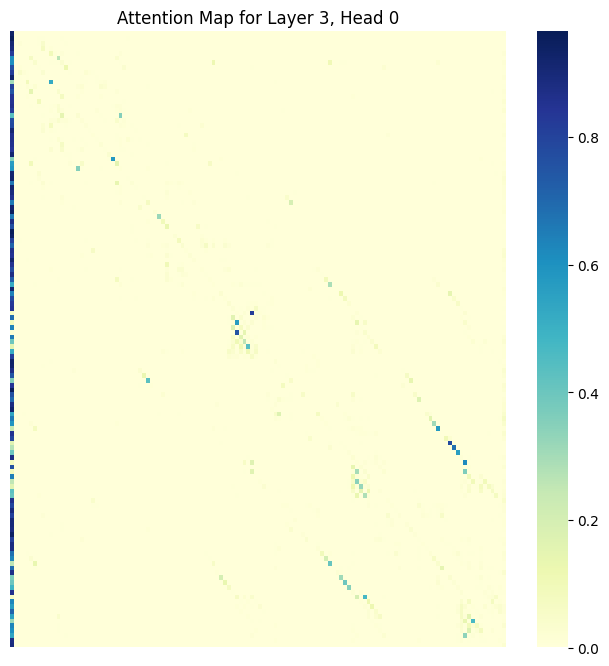

In [28]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Assuming you want to visualize attention for layer 3, head 0
layer_idx = 3
head_idx = 0

# Get the attention scores for the selected layer and head
attention_matrix = attentions_arabic[layer_idx][0][head_idx].cpu().numpy()

# Create a heatmap
plt.figure(figsize=(8, 8))
sns.heatmap(attention_matrix, cmap='YlGnBu', xticklabels=False, yticklabels=False)
plt.title(f'Attention Map for Layer {layer_idx}, Head {head_idx}')
plt.show()
